/home/venky/miniconda3/envs/lsa/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from /home/venky/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


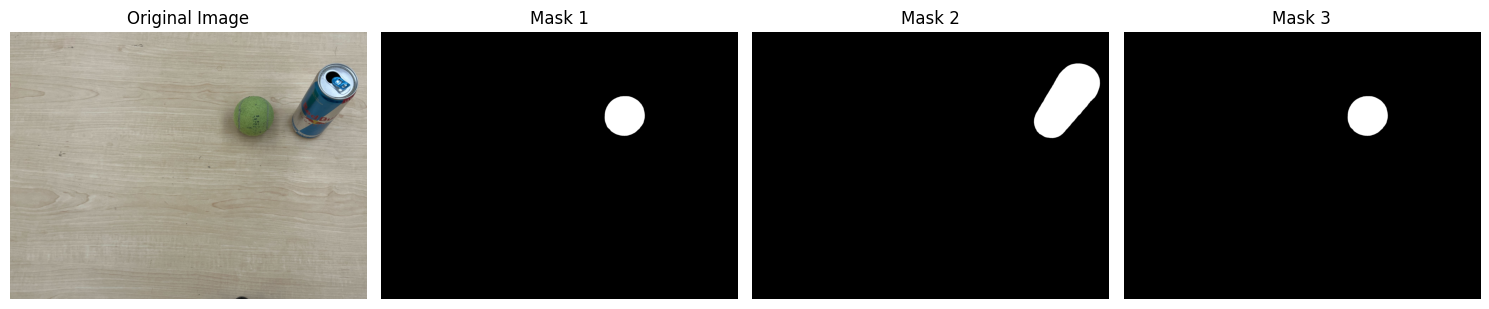

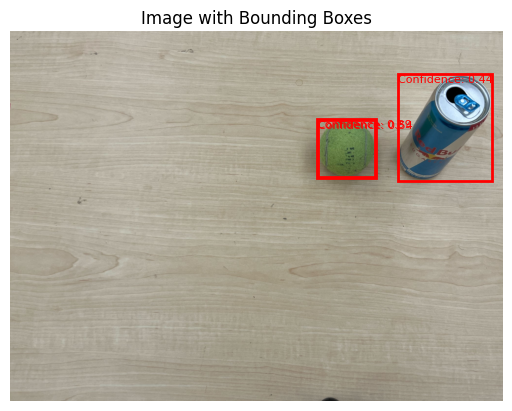

Image representation (image embedding): tensor([[[[-0.1920, -0.2076, -0.1198,  ..., -0.0458, -0.0601, -0.0072],
          [-0.0892, -0.2066, -0.1536,  ..., -0.0733, -0.0620,  0.0359],
          [-0.1617, -0.1521, -0.1729,  ..., -0.0811, -0.1059, -0.0109],
          ...,
          [-0.0286, -0.0504, -0.0550,  ..., -0.1116, -0.1104, -0.1162],
          [-0.0487, -0.0565, -0.0596,  ..., -0.1107, -0.1122, -0.1164],
          [-0.0569, -0.0505, -0.0603,  ..., -0.0977, -0.0944, -0.0815]],

         [[-0.0498, -0.0319,  0.0392,  ...,  0.0315,  0.0088,  0.0044],
          [-0.1326, -0.2132, -0.0717,  ..., -0.2275, -0.2025, -0.0719],
          [-0.1228, -0.1278, -0.2039,  ..., -0.1437, -0.1376,  0.0144],
          ...,
          [ 0.0672,  0.0659,  0.0660,  ...,  0.1170,  0.1210,  0.1036],
          [ 0.0813,  0.0767,  0.0767,  ...,  0.1208,  0.1270,  0.1099],
          [ 0.0862,  0.0999,  0.0954,  ...,  0.1307,  0.1380,  0.1163]],

         [[-0.0577, -0.0187, -0.0281,  ..., -0.0197, -0.0148, 

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from lang_sam import LangSAM

# image = "https://static01.nyt.com/images/2020/09/08/well/physed-cycle-walk/physed-cycle-walk-videoSixteenByNineJumbo1600-v2.jpg"
image = "/home/venky/CogVLM/test_sets/test_set5/IMG_1115.jpg"
text_prompt = "gblue can and green ball"

def download_image(url):
    response = requests.get(url)
    response.raise_for_status()
    return Image.open(BytesIO(response.content)).convert("RGB")

def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)

def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    for i, mask_np in enumerate(masks):
        axes[i+1].imshow(mask_np, cmap='gray')
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def display_image_with_boxes(image, boxes, logits):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Bounding Boxes")
    ax.axis('off')

    for box, logit in zip(boxes, logits):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(logit.item(), 2)  # Convert logit to a scalar before rounding
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Draw bounding box
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

        # Add confidence score as text
        ax.text(x_min, y_min, f"Confidence: {confidence_score}", fontsize=8, color='red', verticalalignment='top')

    plt.show()

def print_bounding_boxes(boxes):
    print("Bounding Boxes:")
    for i, box in enumerate(boxes):
        print(f"Box {i+1}: {box}")

def print_detected_phrases(phrases):
    print("\nDetected Phrases:")
    for i, phrase in enumerate(phrases):
        print(f"Phrase {i+1}: {phrase}")

def print_logits(logits):
    print("\nConfidence:")
    for i, logit in enumerate(logits):
        print(f"Logit {i+1}: {logit}")

def main():
    # Suppress warning messages
    warnings.filterwarnings("ignore")

    try:
        if image.startswith("http"):
            image_pil = download_image(image)
        else:
            image_pil = Image.open(image).convert("RGB")

        model = LangSAM()
        masks, boxes, phrases, logits, image_representation = model.predict(image_pil, text_prompt)

        if len(masks) == 0:
            print(f"No objects of the '{text_prompt}' prompt detected in the image.")
        else:
            # Convert masks to numpy arrays
            masks_np = [mask.squeeze().cpu().numpy() for mask in masks]

            # Display the original image and masks side by side
            display_image_with_masks(image_pil, masks_np)

            # Display the image with bounding boxes and confidence scores
            display_image_with_boxes(image_pil, boxes, logits)

            #Print the image representation (image embedding)
            print(f"Image representation (image embedding): {image_representation}")
            # Get some useful information about the image representation
            print(f"Image representation shape: {image_representation.shape}")
            print(f"Image representation data type: {image_representation.dtype}")



            # Save the masks
            for i, mask_np in enumerate(masks_np):
                mask_path = f"image_mask_{i+1}.png"
                save_mask(mask_np, mask_path)

            # Print the bounding boxes, phrases, and logits
            print_bounding_boxes(boxes)
            print_detected_phrases(phrases)
            print_logits(logits)

    except (requests.exceptions.RequestException, IOError) as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()
